In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc  # Garbage collector

class Capture24DataLoader:
    """Load and process Capture-24 dataset with memory efficiency"""
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.metadata = None
        self.label_dict = None
        self.participants_data = {}
        
    def load_metadata(self):
        """Load metadata and annotation labels"""
        print("Loading metadata...")
        self.metadata = pd.read_csv(self.data_dir / 'metadata.csv')
        self.label_dict = pd.read_csv(self.data_dir / 'annotation-label-dictionary.csv')
        
        print(f"Total participants in metadata: {len(self.metadata)}")
        print(f"Total unique activities: {len(self.label_dict)}")
        print("\nAge distribution:")
        print(self.metadata['age'].value_counts())
        print("\nSex distribution:")
        print(self.metadata['sex'].value_counts())
        
        return self.metadata, self.label_dict
    
    def get_file_size(self, pid):
        """Get file size in MB"""
        filepath = self.data_dir / f'{pid}.csv'
        if filepath.exists():
            size_mb = filepath.stat().st_size / (1024 * 1024)
            return round(size_mb, 2)
        return 0
    
    def load_participant_chunked(self, pid, chunksize=100000):
        """Load participant data in chunks to avoid memory issues"""
        filepath = self.data_dir / f'{pid}.csv'
        if not filepath.exists():
            print(f"Warning: {pid}.csv not found")
            return None
        
        # Read in chunks and concatenate
        chunks = []
        try:
            for chunk in pd.read_csv(filepath, chunksize=chunksize, low_memory=False):
                chunks.append(chunk)
            return pd.concat(chunks, ignore_index=True)
        except MemoryError:
            print(f"Memory error loading {pid}. File too large.")
            return None
    
    def peek_participant(self, pid, nrows=1000):
        """Load only first N rows of participant data for quick inspection"""
        filepath = self.data_dir / f'{pid}.csv'
        if filepath.exists():
            return pd.read_csv(filepath, nrows=nrows, low_memory=False)
        else:
            print(f"Warning: {pid}.csv not found")
            return None
    
    def get_participant_summary(self, pid):
        """Get summary without loading full file"""
        filepath = self.data_dir / f'{pid}.csv'
        if not filepath.exists():
            return None
        
        # Load just first row to get columns
        sample = pd.read_csv(filepath, nrows=1)
        
        # Count total rows efficiently
        with open(filepath, 'r') as f:
            row_count = sum(1 for _ in f) - 1  # -1 for header
        
        meta = self.metadata[self.metadata['pid'] == pid].iloc[0]
        
        return {
            'pid': pid,
            'age_group': meta['age'],
            'sex': meta['sex'],
            'num_records': row_count,
            'file_size_mb': self.get_file_size(pid),
            'columns': list(sample.columns)
        }
    
    def load_participants_selective(self, pids_list):
        """Load only specific participants"""
        print(f"\nLoading {len(pids_list)} selected participants...")
        
        for pid in tqdm(pids_list):
            data = self.load_participant_chunked(pid)
            if data is not None:
                self.participants_data[pid] = data
            gc.collect()  # Force garbage collection
        
        print(f"\nSuccessfully loaded {len(self.participants_data)} participants")
        return self.participants_data
    
    def get_all_summaries(self, start=1, end=87):
        """Get summaries of all participants WITHOUT loading full data"""
        print(f"\nGetting summaries for P{start:03d} to P{end:03d}...")
        
        summaries = []
        for i in tqdm(range(start, end + 1)):
            pid = f'P{i:03d}'
            summary = self.get_participant_summary(pid)
            if summary:
                summaries.append(summary)
        
        return pd.DataFrame(summaries)
    
    def analyze_participant_peek(self, pid, nrows=5000):
        """Analyze a participant with limited data"""
        print(f"\nAnalyzing {pid} (first {nrows} rows)...")
        data = self.peek_participant(pid, nrows=nrows)
        
        if data is None:
            return None
        
        print(f"\nShape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
        print(f"\nData types:")
        print(data.dtypes)
        
        print(f"\nFirst 5 rows:")
        print(data.head())
        
        print(f"\nBasic statistics:")
        print(data.describe())
        
        # Check for accelerometer data
        accel_cols = [c for c in data.columns if c.lower() in ['x', 'y', 'z']]
        if accel_cols:
            print(f"\n✓ Accelerometer columns: {accel_cols}")
        
        # Check for annotations
        if 'annotation' in data.columns:
            print(f"\n✓ Top 10 activities:")
            print(data['annotation'].value_counts().head(10))
        
        return data

# Initialize
data_dir = r"c:\Users\subha\Desktop\Projects\dementia_detection\data\capture24_dataset"
loader = Capture24DataLoader(data_dir)

# Load metadata
metadata, labels = loader.load_metadata()

print("\n" + "="*60)
print("ACTIVITY LABELS")
print("="*60)
print(f"\nAvailable label columns: {list(labels.columns)}")
print(f"\nSample labels (first 10):")
print(labels[['annotation', 'label:Walmsley2020']].head(10))

Loading metadata...
Total participants in metadata: 151
Total unique activities: 206

Age distribution:
age
18-29    43
38-52    37
30-37    37
53+      34
Name: count, dtype: int64

Sex distribution:
sex
F    99
M    52
Name: count, dtype: int64

ACTIVITY LABELS

Available label columns: ['annotation', 'label:WillettsSpecific2018', 'label:WillettsMET2018', 'label:DohertySpecific2018', 'label:Willetts2018', 'label:Doherty2018', 'label:Walmsley2020']

Sample labels (first 10):
                                          annotation label:Walmsley2020
0                             7030 sleeping;MET 0.95              sleep
1  occupation;office and administrative support;1...          sedentary
2  home activity;household chores;preparing meals...              light
3  occupation;office and administrative support;1...          sedentary
4  home activity;miscellaneous;sitting;9060 sitti...          sedentary
5  home activity;miscellaneous;walking;17150 walk...              light
6  transportati

In [2]:
# Get summaries of ALL participants WITHOUT loading full data
print("\n" + "="*60)
print("GETTING FILE SUMMARIES (NO MEMORY ISSUES)")
print("="*60)

all_summaries = loader.get_all_summaries(start=1, end=87)

# Display summary
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(all_summaries)

# Show file sizes
print(f"\nTotal dataset size: {all_summaries['file_size_mb'].sum():.2f} MB")
print(f"Average file size: {all_summaries['file_size_mb'].mean():.2f} MB")
print(f"Largest file: {all_summaries['file_size_mb'].max():.2f} MB")
print(f"Total records: {all_summaries['num_records'].sum():,}")

# Save summary
all_summaries.to_csv('capture24_file_summary.csv', index=False)
print("\n✓ Summary saved to 'capture24_file_summary.csv'")


GETTING FILE SUMMARIES (NO MEMORY ISSUES)

Getting summaries for P001 to P087...


100%|██████████| 87/87 [05:26<00:00,  3.75s/it]


DATASET OVERVIEW
     pid age_group sex  num_records  file_size_mb                      columns
0   P001     38-52   F     10020001       1152.60  [time, x, y, z, annotation]
1   P002     30-37   F      8820001        858.03  [time, x, y, z, annotation]
2   P003     30-37   F      9720001       1048.51  [time, x, y, z, annotation]
3   P004       53+   F      7791785        887.78  [time, x, y, z, annotation]
4   P005     38-52   F      9900001       1067.90  [time, x, y, z, annotation]
..   ...       ...  ..          ...           ...                          ...
82  P083       53+   M      9180001        939.82  [time, x, y, z, annotation]
83  P084     30-37   F     10074001        977.24  [time, x, y, z, annotation]
84  P085       53+   F      9060001       1038.29  [time, x, y, z, annotation]
85  P086     18-29   F      9360001       1013.04  [time, x, y, z, annotation]
86  P087     38-52   F      7980001        897.65  [time, x, y, z, annotation]

[87 rows x 6 columns]

Total data

In [3]:
# Define input and output paths
input_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\data\capture24_dataset\annotation-label-dictionary.csv"
output_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\data\annotation_label_unique_values.txt"

# Load the annotation label dictionary
print(f"Reading from: {input_path}")
labels = pd.read_csv(input_path)

# Display unique values for each column in the label dictionary
print("=" * 60)
print("UNIQUE VALUES IN ANNOTATION-LABEL-DICTIONARY")
print("=" * 60)

for column in labels.columns:
    unique_values = labels[column].unique()
    print(f"\n{column}:")
    print(f"  Number of unique values: {len(unique_values)}")
    print(f"  Unique values:")
    for val in sorted(unique_values):
        count = (labels[column] == val).sum()
        print(f"    - {val} ({count} occurrences)")

# Summary table
print("\n" + "=" * 60)
print("SUMMARY TABLE")
print("=" * 60)
summary_data = []
for col in labels.columns:
    summary_data.append({
        'Column': col,
        'Unique Values': labels[col].nunique()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Export to file
with open(output_path, 'w', encoding='utf-8') as f:
    f.write("ANNOTATION LABEL DICTIONARY - UNIQUE VALUES\n")
    f.write("=" * 80 + "\n")
    f.write(f"Source: {input_path}\n")
    f.write("=" * 80 + "\n\n")
    
    for column in labels.columns:
        unique_values = sorted(labels[column].unique())
        f.write(f"\n{column} ({len(unique_values)} unique values):\n")
        f.write("-" * 80 + "\n")
        for val in unique_values:
            count = (labels[column] == val).sum()
            f.write(f"  {val} ({count})\n")

print(f"\n✓ Input:  {input_path}")
print(f"✓ Output: {output_path}")

Reading from: c:\Users\subha\Desktop\Projects\dementia_detection\data\capture24_dataset\annotation-label-dictionary.csv
UNIQUE VALUES IN ANNOTATION-LABEL-DICTIONARY

annotation:
  Number of unique values: 206
  Unique values:
    - 7030 sleeping;MET 0.95 (1 occurrences)
    - carrying heavy loads;MET 8.0 (1 occurrences)
    - home activity;child/elderly/pet care;MET 2.3 (1 occurrences)
    - home activity;child/elderly/pet care;child care;5181 walking and carrying child;MET 3.0 (1 occurrences)
    - home activity;child/elderly/pet care;child care;5183 standing holding child;MET 2.0 (1 occurrences)
    - home activity;child/elderly/pet care;child care;5185 child care sitting/kneeling  occasional lifting;MET 2.0 (1 occurrences)
    - home activity;child/elderly/pet care;child care;5185 child care sitting/kneeling occasional lifting;MET 2.0 (1 occurrences)
    - home activity;child/elderly/pet care;child care;5185 child care sitting/kneeling;MET 2.0 (1 occurrences)
    - home activity;chi

Loading data from: c:\Users\subha\Desktop\Projects\dementia_detection\data\sleep_training_data.csv
Dataset shape: (270358, 8)

First few rows:
   variance      mean       std  zero_crossing_rate     range  is_sleep  \
0  0.000020  0.970455  0.004491            0.358667  0.028518         1   
1  0.000019  0.970913  0.004386            0.419000  0.029530         1   
2  0.000023  0.971488  0.004760            0.389000  0.045495         1   
3  0.000021  0.971801  0.004613            0.406000  0.030319         1   
4  0.000022  0.971422  0.004688            0.386333  0.038114         1   

  participant  window_index  
0        P001             0  
1        P001             1  
2        P001             2  
3        P001             3  
4        P001             4  

Column names:
['variance', 'mean', 'std', 'zero_crossing_rate', 'range', 'is_sleep', 'participant', 'window_index']

Class distribution:
is_sleep
0    155517
1    114841
Name: count, dtype: int64

Percentage sleep: 42.48%

Fe

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



Training complete!


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished



TRAINING SET PERFORMANCE
Accuracy: 0.8854

Classification Report:
              precision    recall  f1-score   support

        Wake       0.87      0.94      0.90    124413
       Sleep       0.91      0.81      0.86     91873

    accuracy                           0.89    216286
   macro avg       0.89      0.88      0.88    216286
weighted avg       0.89      0.89      0.88    216286


TEST SET PERFORMANCE
Accuracy: 0.8410

Classification Report:
              precision    recall  f1-score   support

        Wake       0.83      0.91      0.87     31104
       Sleep       0.86      0.75      0.80     22968

    accuracy                           0.84     54072
   macro avg       0.84      0.83      0.83     54072
weighted avg       0.84      0.84      0.84     54072


Confusion Matrix:
[[28191  2913]
 [ 5686 17282]]

Confusion matrix saved as 'c:\Users\subha\Desktop\Projects\dementia_detection\results\confusion_matrix.png'


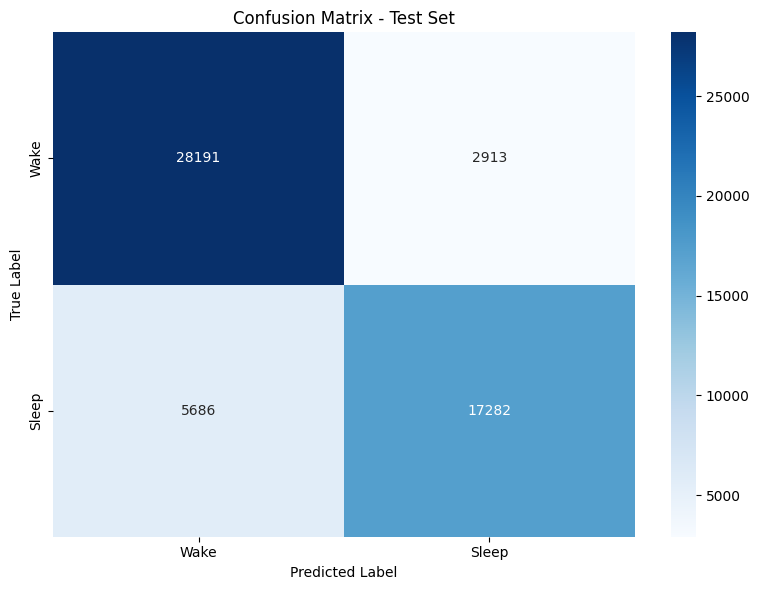


FEATURE IMPORTANCE
           feature  importance
             range    0.372938
          variance    0.244188
               std    0.220709
zero_crossing_rate    0.085868
              mean    0.076297

Feature importance plot saved as 'c:\Users\subha\Desktop\Projects\dementia_detection\results\feature_importance.png'


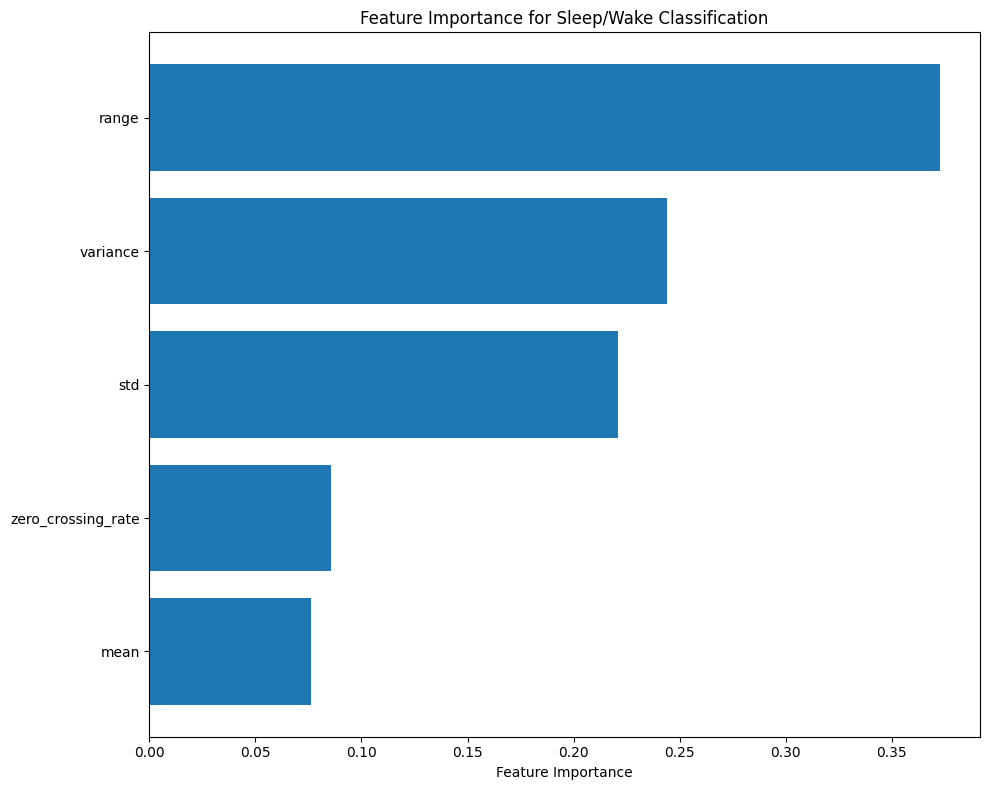


✓ Model saved as 'c:\Users\subha\Desktop\Projects\dementia_detection\models\sleep_wake_model.pkl'
✓ Feature names saved as 'c:\Users\subha\Desktop\Projects\dementia_detection\models\feature_names.pkl'

MODEL SUMMARY
Model type: Random Forest Classifier
Number of trees: 100
Number of features: 5
Training samples: 216286
Test samples: 54072
Test Accuracy: 0.8410

Files created:
  - Model: c:\Users\subha\Desktop\Projects\dementia_detection\models\sleep_wake_model.pkl
  - Features: c:\Users\subha\Desktop\Projects\dementia_detection\models\feature_names.pkl
  - Confusion Matrix: c:\Users\subha\Desktop\Projects\dementia_detection\results\confusion_matrix.png
  - Feature Importance: c:\Users\subha\Desktop\Projects\dementia_detection\results\feature_importance.png

✓ PHASE 1 COMPLETE: Sleep/Wake Model Ready!

Next: Use this model to predict sleep/wake states on new data


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Define file path
data_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\data\sleep_training_data.csv"
model_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\models\sleep_wake_model.pkl"
feature_names_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\models\feature_names.pkl"

# Create models directory if it doesn't exist
import os
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Load the processed training data
print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nClass distribution:")
print(df['is_sleep'].value_counts())
print(f"\nPercentage sleep: {df['is_sleep'].mean()*100:.2f}%")

# Separate features (X) and target (y)
# Drop non-feature columns
feature_cols = ['variance', 'mean', 'std', 'zero_crossing_rate', 'range']
X = df[feature_cols]
y = df['is_sleep']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Train sleep %: {y_train.mean()*100:.2f}%")
print(f"Test sleep %: {y_test.mean()*100:.2f}%")

# Train Random Forest Classifier
print("\n" + "="*60)
print("Training Random Forest Classifier...")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

print("\nTraining complete!")

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate on training set
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Wake', 'Sleep']))

# Evaluate on test set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Wake', 'Sleep']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Wake', 'Sleep'], 
            yticklabels=['Wake', 'Sleep'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
confusion_matrix_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\results\confusion_matrix.png"
os.makedirs(os.path.dirname(confusion_matrix_path), exist_ok=True)
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
print(f"\nConfusion matrix saved as '{confusion_matrix_path}'")
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Sleep/Wake Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
feature_importance_path = r"c:\Users\subha\Desktop\Projects\dementia_detection\results\feature_importance.png"
plt.savefig(feature_importance_path, dpi=300, bbox_inches='tight')
print(f"\nFeature importance plot saved as '{feature_importance_path}'")
plt.show()

# Save the model
joblib.dump(rf_model, model_path)
print(f"\n{'='*60}")
print(f"✓ Model saved as '{model_path}'")
print(f"{'='*60}")

# Save feature names for later use
feature_names = X.columns.tolist()
joblib.dump(feature_names, feature_names_path)
print(f"✓ Feature names saved as '{feature_names_path}'")

# Model summary
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Model type: Random Forest Classifier")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Number of features: {len(X.columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"\nFiles created:")
print(f"  - Model: {model_path}")
print(f"  - Features: {feature_names_path}")
print(f"  - Confusion Matrix: {confusion_matrix_path}")
print(f"  - Feature Importance: {feature_importance_path}")
print("="*60)

print("\n✓ PHASE 1 COMPLETE: Sleep/Wake Model Ready!")
print("\nNext: Use this model to predict sleep/wake states on new data")